In [3]:
# %reset 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import matplotlib.animation as animation
import sys
import sklearn
from datetime import datetime
import tensorflow as tf

np.set_printoptions(precision=3, suppress=True)

In [44]:
## import spreadsheet and select timeframe of interest
from datetime import timedelta
today = datetime.date(datetime.now())
d = datetime.date(datetime.now())
while d.weekday() != 6:
    d += timedelta(1)
sunday = d

dfnfl = pd.read_csv('spreadspoke_scores.csv')
dfnfl.loc[:,'gamedate'] = pd.to_datetime(dfnfl['schedule_date'])
dfnfl.loc[:,'scoredif'] = dfnfl['score_home'] - dfnfl['score_away']
dfnfltime = dfnfl[dfnfl['gamedate'] > pd.to_datetime('2004-07-31')]
dfnfltime = dfnfltime[dfnfltime['gamedate'] < pd.to_datetime('2020-7-20')]
teams = dfnfltime['team_home'].unique()
teamsid = dfnfltime['team_favorite_id'].unique()
dfnfltime

dfnflsunday = dfnfl[dfnfl['gamedate'] == pd.to_datetime(sunday)]

#create dictionary of teams and shortnames
teams_save = ['Chicago Bears', 'St. Louis Rams','Arizona Cardinals', 'Carolina Panthers',
       'Cleveland Browns', 'Dallas Cowboys', 'Jacksonville Jaguars',
       'Los Angeles Chargers', 'Miami Dolphins', 'Minnesota Vikings',
       'New England Patriots', 'New York Jets', 'Philadelphia Eagles',
       'Seattle Seahawks', 'Tampa Bay Buccaneers', 'New Orleans Saints',
       'Las Vegas Raiders','Oakland Raiders', 'Atlanta Falcons', 'Baltimore Ravens',
       'Cincinnati Bengals', 'Denver Broncos', 'Detroit Lions',
       'Green Bay Packers', 'Houston Texans', 'Los Angeles Rams',
       'New York Giants', 'Pittsburgh Steelers', 'Tennessee Titans',
       'Washington Redskins', 'Buffalo Bills', 'Indianapolis Colts','San Diego Chargers',
       'Kansas City Chiefs', 'San Francisco 49ers'] 

ids = ['CHI', 'STL','ARI', 'CAR', 'CLE', 'DAL', 'JAC', 'LAC', 'MIA', 'MIN', 'NE',
       'NYJ', 'PHI', 'SEA', 'TB', 'NO', 'LV','OAK', 'ATL', 'BAL', 'CIN', 'DEN',
       'DET', 'GB', 'HOU', 'LAR', 'NYG', 'PIT', 'TEN', 'WAS', 'BUF',
       'IND','SD', 'KC','SF']
teamids = {teams_save[i]: ids[i] for i in range(len(teams_save))}
#teamids = {teams[i]: teamsid[i] for i in range(len(teams))}

#split dataframe from game indexed (home and away) to each teams score and spread
dfnfltimehome = dfnfltime[['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home','team_favorite_id','spread_favorite','gamedate', 'scoredif']]
dfnfltimehome.loc[:,'team'] = dfnfltimehome['team_home']
dfnfltimehome.loc[:,'score'] = dfnfltimehome['score_home']
dfnfltimeaway = dfnfltime[['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_away', 'score_away','team_favorite_id','spread_favorite','gamedate', 'scoredif']]
dfnfltimeaway.loc[:,'team'] = dfnfltimeaway['team_away']
dfnfltimeaway.loc[:,'score'] = dfnfltimeaway['score_away']
dfnfltimeaway.loc[:,'scoredif'] = -dfnfltimeaway['scoredif']
dfnfltimesingle = pd.concat([dfnfltimehome,dfnfltimeaway])
dfnfltimesingle.drop(['score_home', 'team_home','team_away','score_away'], axis=1, inplace=True)
teamids

#calculate each teams score ATS and whether covered ATS
def spread(team,team_favorite_id,scoredif,spread_favorite,teamids):
    if teamids[team] == team_favorite_id:
        spreadscore = scoredif + spread_favorite
        if spreadscore > 0:
            cover = 1
        if spreadscore < 0:
            cover = -1
        if spreadscore == 0:
            cover = 0
            
    if teamids[team] != team_favorite_id:
        spreadscore = scoredif - spread_favorite
        if spreadscore > 0:
            cover = 1
        if spreadscore < 0:
            cover = -1
        if spreadscore == 0:
            cover = 0
    return spreadscore
def cover(team,team_favorite_id,scoredif,spread_favorite,teamids):
    if teamids[team] == team_favorite_id:
        spreadscore = scoredif + spread_favorite
        if spreadscore > 0:
            cover = 1
        if spreadscore < 0:
            cover = -1
        if spreadscore == 0:
            cover = 0
            
    if teamids[team] != team_favorite_id:
        spreadscore = scoredif - spread_favorite
        if spreadscore > 0:
            cover = 1
        if spreadscore < 0:
            cover = -1
        if spreadscore == 0:
            cover = 0
    return cover

dfnfltimesingle['spreadscore'] = dfnfltimesingle.apply(lambda row: spread(row['team'],row['team_favorite_id'],row['scoredif'],row['spread_favorite'],teamids),axis=1)
dfnfltimesingle['cover'] = dfnfltimesingle.apply(lambda row: cover(row['team'],row['team_favorite_id'],row['scoredif'],row['spread_favorite'],teamids),axis=1)


#regular season only
dfnfltimesingle = dfnfltimesingle[dfnfltimesingle['schedule_playoff']== False]
dfnfltimesingle.drop(['schedule_playoff'], axis=1, inplace=True)
# dfnfltimesingle.sort_values(by=['schedule_week'],inplace = True)
dfnfltimesingle = dfnfltimesingle.reset_index()


### get each teams score ATS each week of the season, concat seasons vertically
years = dfnfltimesingle['schedule_season'].unique()
dfspreadall = []
dfcoverall = []
for year in years:
#     print(year)
    dfnfltimesingleloop = dfnfltimesingle[dfnfltimesingle['schedule_season']==year]
    dfnfltimesingleloop.sort_values(by=['gamedate'],inplace=True)
    #create dataframe of score ATS for each team through the season
    dfspread = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingle['team'] == teams_save[0]]['spreadscore']).reset_index(drop=True)
    for team in teams_save:
        if team != teams_save[0]:
            seasonspread = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingleloop['team'] == team]['spreadscore']).reset_index(drop=True)
            dfspread = pd.concat([dfspread,seasonspread],axis=1)    
    dfspread.columns = teams_save
    dfspread = dfspread.transpose()
    #drop las vegas raiders because they didnt exist yet
    dfspread.dropna(inplace=True)


    #create dataframe of score ATS for each team through the season
    dfcover = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingleloop['team'] == teams_save[0]]['cover']).reset_index(drop=True)
    for team in teams_save:
        if team != teams_save[0]:
            seasoncover = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingleloop['team'] == team]['cover']).reset_index(drop=True)
            dfcover = pd.concat([dfcover,seasoncover],axis=1)    
    dfcover.columns = teams_save
    dfcover = dfcover.transpose()
    #drop las vegas raiders because they didnt exist yet
    dfcover.dropna(inplace=True)
    dfspreadall.append(dfspread)
    dfcoverall.append(dfcover)
dfspreadall = pd.concat(dfspreadall)
dfcoverall = pd.concat(dfcoverall)
dfspreadall

dfspreadall.to_excel('dfspreadall.xlsx')
dfcoverall.to_excel('dfcoverdall.xlsx')


C:\Users\hogan\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\hogan\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\hogan\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

In [45]:
df = dfspreadall

#####need to think how to use a 3d dataframe
#df = df.values.reshape(df.shape[1],16,1)

#for now use all games consecutively
df = df.values.reshape(-1,1)
df = pd.DataFrame(df)


In [46]:
df = dfspreadall
games = 7 ##past games to consider while predicting next one
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence
# choose a number of time steps
# split into samples    
X = []
y = []
for i in range(len(df)):
    raw_seq = df.iloc[i]
    # choose a number of time steps
    n_steps = games
    # split into samples
    Xteam, yteam = split_sequence(raw_seq, n_steps)
    X.append(Xteam[0:])
    y.append(yteam[0:])
X = array([item for sublist in X for item in sublist])
y = array([item for sublist in y for item in sublist])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


48/48 [==============================] - 0s 1ms/step - loss: 399.3056 - accuracy: 0.0250
Test score: 399.3056335449219
Test accuracy: 0.024983562529087067


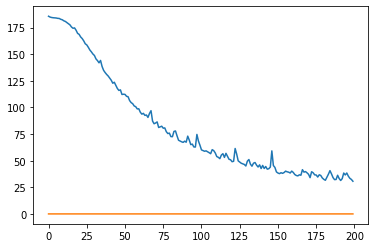

In [50]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train, epochs=200, verbose=0)

score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

C:\Users\hogan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

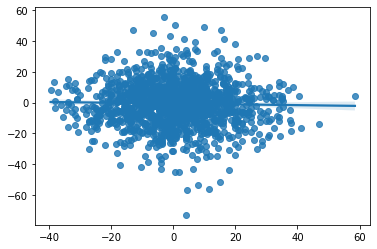

In [51]:
# demonstrate prediction
ypred = []
ytest = []
for game in range(len(y_test)):
    x_input = X_test[game]
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
#     print(yhat[0][0])
#     print(y_test[game])
    ypred.append(yhat[0][0])
    ytest.append(y_test[game])

import seaborn as sns
sns.regplot(ytest,ypred)

In [52]:
##### So far no predictive power using old spreads to predict next games

In [53]:
#### LSTM #####
#and others before

df = dfspreadall
#####need to think how to use a 3d dataframe
#df = df.values.reshape(df.shape[1],16,1)

#for now use all games consecutively, two rows
df = df.values.reshape(-1,1)
df = pd.DataFrame(df)
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


In [54]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [55]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [56]:
label = 0

w1 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=[label])
w1

w2 = WindowGenerator(input_width=3, label_width=1, shift=1,
                     label_columns=[label])
w2

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): [0]

In [57]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [58]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[3:3+w2.total_window_size]),
                           np.array(train_df[6:6+w2.total_window_size])])

# print(train_df[:w2.total_window_size])
# print(train_df[3:3+w2.total_window_size])
# print(train_df[6:6+w2.total_window_size])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 4, 1)
Inputs shape: (3, 3, 1)
labels shape: (3, 1, 1)


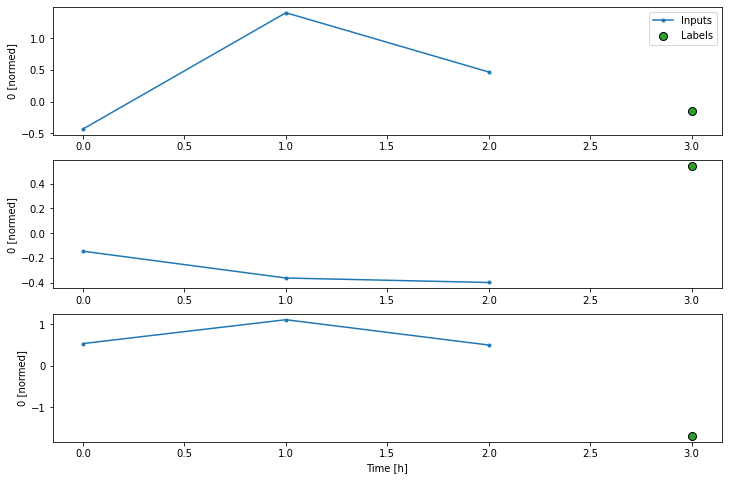

In [59]:
w2.example = example_inputs, example_labels
def plot(self, model=None, plot_col=0, max_subplots=5):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

w2.plot()

In [60]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=5000,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [61]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [62]:
# Each element is an (inputs, label) pair
w2.train.element_spec
w2.val.element_spec
w2.test.element_spec

(TensorSpec(shape=(None, 3, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [63]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (5000, 3, 1)
Labels shape (batch, time, features): (5000, 1, 1)


In [64]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[label])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): [0]

In [65]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (5000, 1, 1)
Labels shape (batch, time, features): (5000, 1, 1)


In [66]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[label])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): [0]

In [67]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (5000, 1, 1)
Labels shape (batch, time, features): (5000, 1, 1)


In [84]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [94]:
#### baseline model simply predicts same as last game
baseline = Baseline(label_index=column_indices[label])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 155ms/step - loss: 1.6551 - mean_absolute_error: 1.0047


In [95]:
threegame_window = WindowGenerator(
    input_width=3, label_width=3, shift=1,
    label_columns=[label])

threegame_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [1 2 3]
Label column name(s): [0]

Input shape: (5000, 3, 1)
Output shape: (5000, 3, 1)


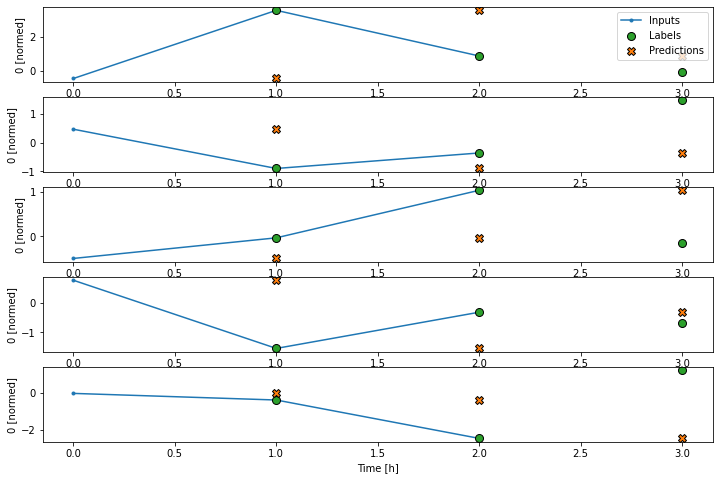

In [96]:
print('Input shape:', threegame_window.example[0].shape)
print('Output shape:', baseline(threegame_window.example[0]).shape)
threegame_window.plot(baseline)

In [97]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=[label])

wide_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): [0]

In [98]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [90]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (5000, 1, 1)
Output shape: (5000, 1, 1)


In [103]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping],verbose=0)
  return history

In [104]:
history = compile_and_fit(linear, wide_window)

val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 64ms/step - loss: 0.9202 - mean_absolute_error: 0.7402


Input shape: (5000, 7, 1)
Output shape: (5000, 7, 1)


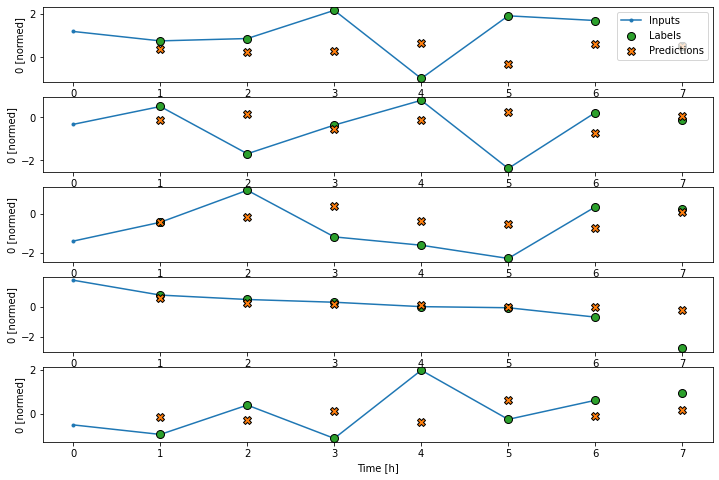

In [105]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
wide_window.plot(linear)

1/1 [==============================] - 0s 65ms/step - loss: 0.8492 - mean_absolute_error: 0.7054


Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

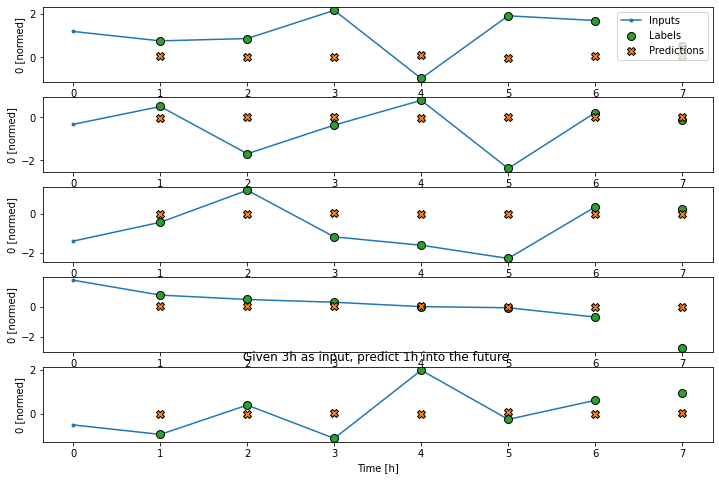

In [106]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, wide_window)

val_performance['Dense'] = dense.evaluate(wide_window.val)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

%matplotlib inline
wide_window.plot(dense)
plt.title("Given 3h as input, predict 1h into the future.")

In [107]:
CONV_WIDTH = 7
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[label])

conv_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): [0]

In [108]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (5000, 7, 1)
Output shape: (5000, 1, 1)


In [109]:
import IPython
history = compile_and_fit(multi_step_dense, conv_window)

%matplotlib widget
IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 50ms/step - loss: 0.8618 - mean_absolute_error: 0.7128


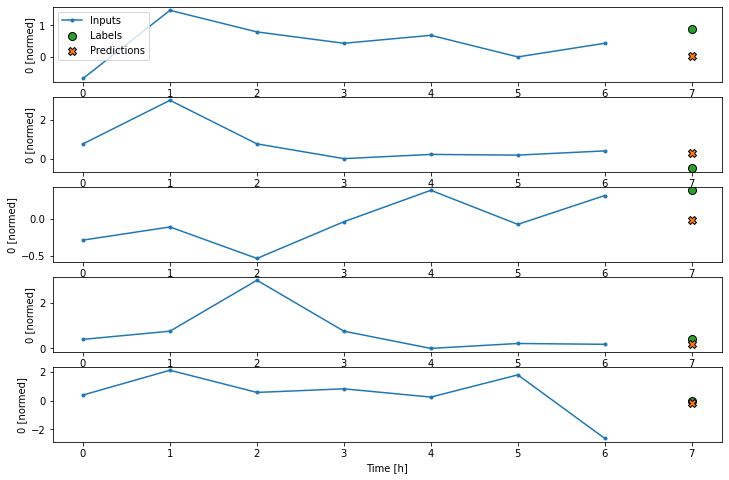

In [110]:
%matplotlib inline
conv_window.plot(multi_step_dense)

In [111]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (5000, 7, 1)
Output shape: (5000, 1, 1)


In [112]:
conv_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): [0]

In [113]:
history = compile_and_fit(conv_model, conv_window)

import IPython.display
IPython.display.clear_output()
#cant bring test and val scores to final df, code below tries to do that
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 64ms/step - loss: 0.8457 - mean_absolute_error: 0.7076


Wide window
Input shape: (5000, 7, 1)
Labels shape: (5000, 1, 1)
Output shape: (5000, 1, 1)


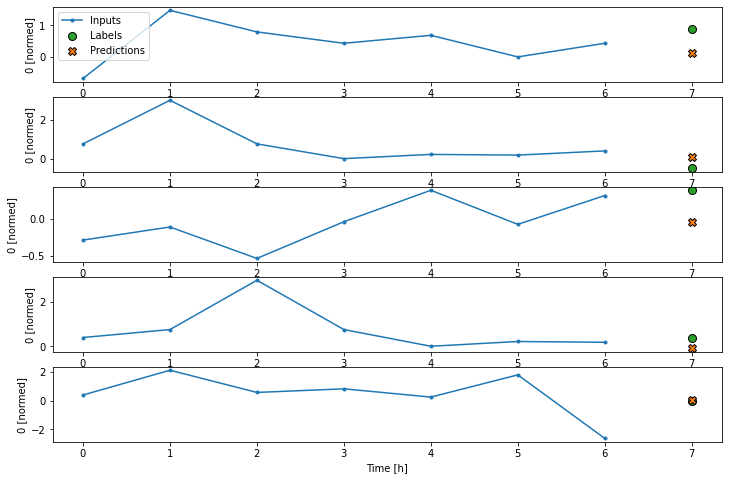

In [114]:
print("Wide window")
print('Input shape:', conv_window.example[0].shape)
print('Labels shape:', conv_window.example[1].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)
conv_window.plot(conv_model)

In [115]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (5000, 7, 1)
Output shape: (5000, 7, 1)


In [116]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (5000, 7, 1)
Output shape: (5000, 7, 1)


In [117]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 56ms/step - loss: 0.8497 - mean_absolute_error: 0.7059


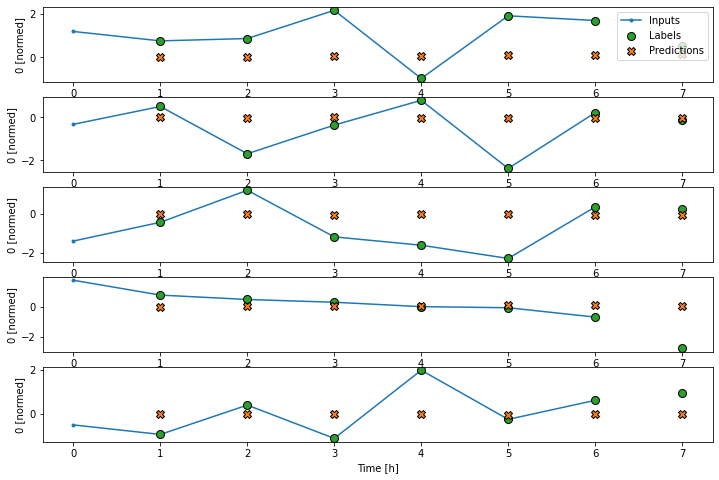

In [118]:
wide_window.plot(lstm_model)

Baseline    : 1.0516
Linear      : 0.7792
Dense       : 0.7356
Multi step dense: 0.7459
Conv        : 0.7410
LSTM        : 0.7370


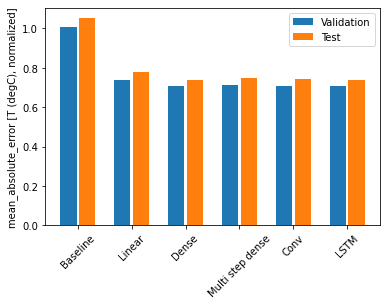

In [119]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')